In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

## Algorithm 1 (features + labels private)

<img src="../image/alg1_2019.png" width="400" height="200">

In [2]:
def sample_dataset(n, p, c, k):
    x = np.random.choice([-1, 1], (n, p))
    noise = np.random.uniform(-c, c, n)
    
    theta_star = np.random.uniform(-1, 1, p)

    # make theta_star k-sparse randomly
    index = np.random.choice(range(p), k)
    for i in index:
        theta_star[i] = 0
        
    y = x @ theta_star + noise
    return x, y, theta_star

In [3]:
def experiment_setup(n, p):
    T = int(np.ceil(np.log2(n / p))) # number of iterations, rounded-up
    bucket_size = int(np.floor(n / T))
    theta_prev = np.zeros(p) # theta_zero

    index_set = [] # splitting into buckets
    for t in range(T):
        start = t * bucket_size
        end = (t + 1) * bucket_size - 1
        if t == T - 1:
            end = n - 1
            
        index_set.append((start, end))

    return T, theta_prev, index_set

In [4]:
T, theta_prev, index_set = experiment_setup(500000, 16)

In [5]:
theta_prev

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
T

15

In [7]:
index_set

[(0, 33332),
 (33333, 66665),
 (66666, 99998),
 (99999, 133331),
 (133332, 166664),
 (166665, 199997),
 (199998, 233330),
 (233331, 266663),
 (266664, 299996),
 (299997, 333329),
 (333330, 366662),
 (366663, 399995),
 (399996, 433328),
 (433329, 466661),
 (466662, 499999)]

In [8]:
def randomizer(x):
    return x

# TODO - implement randomizer

In [21]:
# params: v - vector, k - sparsity
# returns an updates vector v which is k-sparse

def truncation(v, k):
    p = len(v)
    v_abs = np.abs(v)
    
    argmin_k_indices = np.argpartition(v_abs, -(p - k))[:(p - k)]
    
    for j in argmin_k_indices:
            v[j] = 0

    return v

In [22]:
truncation([-100, 2, 3, 4, 5, 6, 7], 3)

[-100, 0, 0, 0, 0, 6, 7]

In [49]:
def run_experiment(n, p, k=3, eta=0.1, c=0.05, verbose=False):
    x, y, theta_star = sample_dataset(n, p, c, k)
    T, theta_prev, index_set = experiment_setup(n, p)
    
    for t in range(T):
        if verbose:
            print(f'\n============================== iteration {t} ==================================')
        
        all_gradients = []
        # Line 3: users computes their gradient locally and adds noise (randomizer)
        for i in range(index_set[t][0], index_set[t][1] + 1):
            nabla_i = x[i].T * (theta_prev @ x[i] - y[i])
            nabla_i = randomizer(nabla_i) # currently, identity function
            all_gradients.append(nabla_i)

        if verbose:
            print("\nAll gradients input")
            print(np.array(all_gradients).shape)

        # Line 4: aggregate gradients
        nabla_prev = np.array(all_gradients).sum(axis=0) / len(all_gradients)
        if verbose:
            print("\nLine 4. Aggregated gradient")
            print(np.array(nabla_prev).shape)
    
        # Line 5: perform gradient descend
        theta_t = theta_prev - eta * nabla_prev
        if verbose:
            print("\nLine 5. Gradient descent")
            print(theta_t)
    
        # Line 6: truncation - make k-sparse
        theta_t = truncation(theta_t, k)
        if verbose:
            print("\nLine 6. Make sparse")   
            print(theta_t)

        # Line 7: l2 ball projection
        norm_theta_t = LA.norm(theta_t, ord=2)
        if norm_theta_t > 1:
            theta_t = theta_t / norm_theta_t
        if verbose:
            print("\nLine 7. L2 projection to ball")   
            print(theta_t)

        # update for next iteration
        theta_prev = theta_t


    # compute error
    e = LA.norm(theta_t - theta_star, ord=2) / LA.norm(theta_star, ord=2)
    return e

In [50]:
# DEBUG
# run_experiment(100, 10, k=5, eta=0.2)

## Experiment 1 - varying dimensionality (p) - figure 1a

In [51]:
n_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
p_values = [16, 64, 128, 256]
k = 10
results = {}

In [52]:
for n in n_values:
    for p in p_values:
        errors = []
        for i in range(10):
            e = run_experiment(int(n * (10 ** 5)), p, k, eta=0.1, c=0.05, verbose=False)
            errors.append(e)
            
        if not p in results:
            results[p] = []
        results[p].append(np.mean(errors))
        print(n, p, np.mean(errors))

1 16 0.38723601752813713
1 64 0.9050809842085472
1 128 0.95846050165755
1 256 0.9774195510812158
1.5 16 0.3717422986067107
1.5 64 0.8970866329522211
1.5 128 0.9492076695760602
1.5 256 0.9786980734311145
2 16 0.3801259671051615
2 64 0.9020941932535639
2 128 0.9550213668517813
2 256 0.977633609196922
2.5 16 0.35742566361018846
2.5 64 0.8864275598891863
2.5 128 0.9526140553616094
2.5 256 0.980307424323177
3 16 0.35651305406132394
3 64 0.9007132664192359
3 128 0.9528715265972325
3 256 0.9800302400400349
3.5 16 0.39952750829726047
3.5 64 0.8926175814087423
3.5 128 0.9559387681954501
3.5 256 0.9761445232426228
4 16 0.3896215757769038
4 64 0.8990877404872958
4 128 0.9549810092317707
4 256 0.9759156170141914
4.5 16 0.3406188936650457
4.5 64 0.8962752545418408
4.5 128 0.956213621166599
4.5 256 0.9773030303230608
5 16 0.4064654952450998
5 64 0.8975646471444086
5 128 0.9549907229048941
5 256 0.9782886276497648


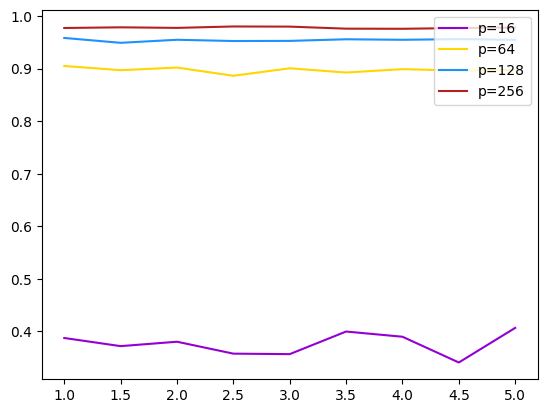

In [53]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for i in range(len(p_values)):
    p = p_values[i]
    plt.plot(n_values, results[p], label=f'p={p}', color=colors[i])

plt.legend(loc=1)
plt.show()

## Experiment 2 - varying sparsity level (k) - figure 1b

In [30]:
n_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
k_values = [10, 20, 40, 100]
p = 64
results = {}

In [31]:
for n in n_values:
    for k in k_values:
        min_error = 1.0
        for i in range(10):
            e = run_experiment(int(n * (10 ** 5)), p, k, eta=0.1, c=0.05, verbose=False)
            if e < min_error:
                min_error = e
            
        if not k in results:
            results[k] = []
        results[k].append(min_error)
        print(n, k, min_error)

1 10 0.8718019222394388
1 20 0.7655773553381587
1 40 0.6413487287201525
1 100 0.34260192264139594
1.5 10 0.8606712842509058
1.5 20 0.7899654064763003
1.5 40 0.6098570809129568
1.5 100 0.2803802420511201
2 10 0.8684978789934126
2 20 0.7386289799767206
2 40 0.6904245974414926
2 100 0.2805540822338954
2.5 10 0.8810301378898991
2.5 20 0.7735264755951696
2.5 40 0.6458883478197032
2.5 100 0.4106476604619845
3 10 0.8458191237118771
3 20 0.8055264642413986
3 40 0.6555346823536433
3 100 0.4158726848848608
3.5 10 0.8478165926469299
3.5 20 0.768909159307574
3.5 40 0.6620394002486621
3.5 100 0.397878109396738
4 10 0.8592565613228673
4 20 0.8008009682428152
4 40 0.6791289641844817
4 100 0.39300259599154785
4.5 10 0.8553699360363346
4.5 20 0.8037815168287663
4.5 40 0.6633047758404658
4.5 100 0.3630722382915893
5 10 0.8623527372759098
5 20 0.7550085812268854
5 40 0.6482338975124542
5 100 0.4010220091251581


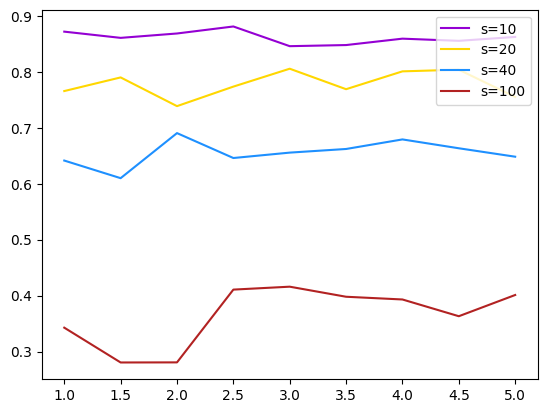

In [32]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for i in range(len(k_values)):
    k = k_values[i]
    plt.plot(n_values, results[k], label=f's={k}', color=colors[i])

plt.legend(loc=1)
plt.show()